# 機械学習フロー
# 【問題1】クロスバリデーション
事前学習期間は検証データを分割しておき、それに対して指標値を計算することで検証を行っていました。しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション を行います。


具体的には分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割を行う関数はscikit-learnにKFoldとして用意されています。
## データの確認

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
train_x = train_df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']].copy()
train_y = train_df['TARGET'].copy()
train_x['CODE_GENDER'] = train_x['CODE_GENDER'].map({'M' : 0, 'F' : 1, 'XNA' : 2}).astype(int) # 性別のダミー変数
train_x['NAME_FAMILY_STATUS'] = train_x['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4, 'Unknown' : 5}).astype(int) # 性別のダミー変数

In [3]:
unique_name, count = np.unique(train_x.CODE_GENDER, return_counts=True) # 0:mele, 1:female, 2:XNA
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'], index=train_x.CODE_GENDER.unique())

,unique_name,count
0,0,105059
1,1,202448
2,2,4


In [4]:
unique_name, count = np.unique(train_x.NAME_FAMILY_STATUS, return_counts=True) # 'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4, 'Unknown':5
pd.DataFrame(list(zip(unique_name, count)), columns = ['unique_name','count'], index=train_x.NAME_FAMILY_STATUS.unique())

,unique_name,count
3,0,29775
1,1,196432
0,2,19770
4,3,45444
2,4,16088
5,5,2


In [5]:
from sklearn.model_selection import train_test_split # データ分割
train_x75, test_x25 = train_test_split(train_x.values, random_state=0).copy()
train_y75, test_y25 = train_test_split(train_y.values, random_state=0).copy()

## 前回のモデル

,th_all,tpr_all,fpr_all
0,1.250149,0.000000,0.000000
1,0.250149,0.000000,0.000014
2,0.243299,0.000000,0.000071
3,0.243016,0.000164,0.000071
4,0.240022,0.000164,0.000297
...,...,...,...
11132,0.006934,0.999672,0.999732
11133,0.006735,0.999836,0.999732
11134,0.001834,0.999836,0.999958
11135,0.001798,1.000000,0.999958


AUC : 0.5863008543227801


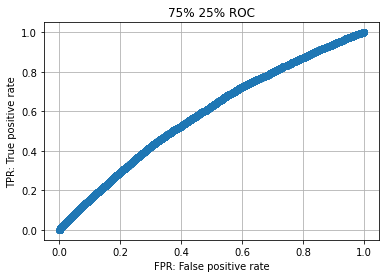

In [6]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as me
from sklearn.metrics import classification_report

logi = LogisticRegression()
logi.fit(train_x75, train_y75)
logi_pred75 = logi.predict(test_x25)

from sklearn.metrics import roc_auc_score
fpr_all, tpr_all, th_all  = me.roc_curve(test_y25, logi.predict_proba(test_x25)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
plt.plot(fpr_all, tpr_all, marker='o')
plt.title('75% 25% ROC')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
display(df_roc)
print('AUC : {}'.format(roc_auc_score(test_y25, logi.predict_proba(test_x25)[:, 1])))

## クロスバリデーション

AUC : 0.5891351125675032
AUC : 0.5894570986521924
AUC : 0.5914275958872054
AUC : 0.5848473189483524
AUC : 0.5937716483435159


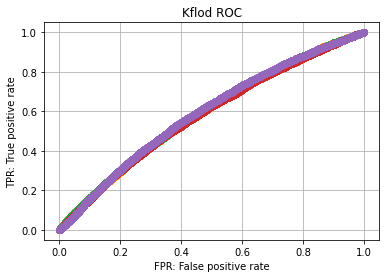

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(train_x): # listでindexの値をndarrayで返却してる indexの数はx,y同数なので片方でおk
    train_xk, test_xk = train_x.iloc[train_index], train_x.iloc[test_index]
    train_yk, test_yk = train_y.iloc[train_index], train_y.iloc[test_index]
    logi_k = LogisticRegression()
    logi_k.fit(train_xk, train_yk)
    logi_k_pred = logi_k.predict(test_xk)
    fpr_all, tpr_all, th_all  = me.roc_curve(test_yk, logi_k.predict_proba(test_xk)[:, 1], pos_label=1)# 正解ラベル１を1に設定、なのでみるべきなのは0を取る時の確率密度
    df_roc = pd.DataFrame({'th_all': th_all, 'tpr_all': tpr_all, 'fpr_all': fpr_all}) # 閾値、再現率(recall)、陰性を間違えて陽性と判断した場合
    plt.plot(fpr_all, tpr_all, marker='o')
    plt.title('Kflod ROC')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    print('AUC : {}'.format(roc_auc_score(test_yk, logi_k.predict_proba(test_xk)[:, 1])))

## 【問題2】グリッドサーチ
これまで分類器のパラメータは基本的にデフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになりますが、パラメータは状況に応じて最適なものを選ぶ必要があります。パラメータを探索するために グリッドサーチ と呼ばれる総当たり的手法が一般的に利用されます。


グリッドサーチをパイプラインの中に組み込みましょう。

## penaltyについて
default = L2
- L1  
    いくつかの特徴量を0にしてしまって過学習を防ぐやり方  
    今回学習できていないのは0にしすぎてるから？  
    課題としてサンプル数nより特徴量pが大きい場合、pの取れる最大値はnになってしまう
- L2  
    数値の絶対量を減らすことで過学習を防ぐやり方。イメージとして標準化と同じ？  
    ただ、今回NONEと同じスコアなのでそもそも上手く使えてない説がある  
- elasticnet  
    L1,L2の両方を使用して使うやり方。L1とL2bの前に重みをつけることによって最適な値を回数を回すことで求めようとするやり方。  
    L1が使えてないのであれば、L２に自動的に切り替えてほしかったけどそういうわけにもいかないのかな  
    とりあえずこれを使えばいいと思うのだけれどdelaoutがl2なのでなんらかの欠点があるのかもしれない
- NONE  
    多分なんの正則化も行なっていない  
  


In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
# from sklearn.model_selection import GridSearchCV
# penalty = {'penalty' : ['l1', 'l2', 'elasticnet', 'none']}
# logi_t = LogisticRegression()
# clf = GridSearchCV(logi_t, penalty, cv=5, scoring='roc_auc')
# clf.fit(train_x75, train_y75)

In [10]:
# print('best_score : {}'.format(clf.best_score_)) # このスコアは交差検証の平均値？？？
# print('best_param : {}'.format(clf.best_params_))# 一番良かったのを返す

In [11]:
# clf.cv_results_ # 各結果、そもそもL1とelasticnetは使えてない....理由はおいおい

今回に関してはそもそもL2とNONEしか使えていない。  
なんなら使えているL2と　noneのスコアも全く同じになってる。。。。  
可能性としてはCをデフォルトの値(1)のままにしているので効果がてていないのかぁ

## sloverについて

L1とelasticnetが使えなかった諸悪の根源  
交差エントロピー誤差関数(後述)を最小化するための方法  
- newton-cg  
- lbfgs
- liblinear
- sag
- saga

### Newton_cg(ニュートン共役勾配法)
#### ニュートン法について
![Imgur](https://i.imgur.com/OiTCnJ6l.jpg)  
上記グラフの時x軸との交点αを求めたいという時に使うもの方法
最適化問題でグラフが複雑になったときにどんなグラフでも近似的に答えを見つけられるという関数

上記グラフの交点に対して接線の方程式を使い

$$y-f(x_n) = f'(x_n)(x-x_n)$$

が成立する。この式を式変形することで

$$x_{n+1}=x_n-\frac{f(x)}{f'(x)}$$

が成立し、この式はxだけで解けるので無限回行うことでαが求められるというもの。

#### 共益勾配法について

この方の記事を参考にしてください : [https://qiita.com/Dason08/items/27559e192a6a977dd5e5](https://qiita.com/Dason08/items/27559e192a6a977dd5e5)

イメージで言うと、勾配降下法で今いる地点の勾配から徐々にゴールを目指していたのを、ゴールへの向きを固定し勾配からベクトル力を決めてしまうというもの。
理論上、向きと力が100%あっていれば一発で最適化ができるよねっていう手法。
またずれていたとしても、その向きから垂直方向に調整を行うため一度調整したベクトルは変更されない。
(垂直ベクトルは0になるため)

#### ふたつを組み合わせると

ニュートン法や勾配降下法の弱点であった鞍点で止まってしまうことを防げるらしい
ベクトルでの調整になるのでL2ノルムでしか使えない。

### lbfgs法
ニュートン法の弱点である微分をなくした最適化手法
メモリ(memoly)に優しくb,f,g,sパラメータを使うためこの名前が付けられている。

ニュートン法は次の値(n+1)を求めるののに微分を用いる。
微分によりヘッセ行列が作成される。
例えば

$$5x^2+3xy+6y^2=4$$

のヘッセ行列Hは(x^2,xy,y^2で微分)

$$
\begin{pmatrix}
10 & 3 \\\
3 & 12
\end{pmatrix}
$$

となる。この値が特徴量の2乗の値になるため、膨大なメモリを食ってしまうのを防ぐための手法。
ヘッセ行列を使わず、H^-1に近い行列Bを仮定し、この値を求めるやり方。
Bの求め方は省略するが、各方向への勾配gと移動量sを用いて算出できる。
またニュートン法のようにハイパーパラメータが存在せず、振動することがないのが特徴。

### liblinear
オープンソースの機械学習ライブラリらしい。
公式[https://www.csie.ntu.edu.tw/~cjlin/liblinear/](https://www.csie.ntu.edu.tw/~cjlin/liblinear/)
座標降下法をもちいてロジスティック回帰を行なっているものと、線形SVMをもちいて学習するものがある。
scikit-learnがどちらを使っているかは不明。

#### 座標降下法について

イメージでいうと各特徴量にたいして順番に更新していく仕組み。
2次元だと考えると
$$x_1 , y_1 , x_2, y_2, x_3 ...$$

３次元ならば
$$x_1, y_1, z_1, x_2, y_2, z_2, x_3...$$
のように、求めたい変数以外を定数と仮定して解く方法。

![image](https://research.miidas.jp/wp-content/uploads/2019/02/Screen-Shot-2019-02-24-at-19.59.08.png)

メリット 
- 特徴量を一つづつ更新していくため、メモリ容量に優しい。
- 超大規模データ等で使用できる
- 一度に更新するのは一つのパラメーターなので、そこまで計算に時間がかからないこと。

デメリット
- スパース問題(特徴がまんべんなくではなく、ある特徴量の比率が大きい)に使用できない。
- 最適解に精密さを必要と場合、使えない。

#### 本題
公式docには小さなデータセットでいい選択だと記載されているため、SVMをもちいた最適化方法なのかもしれない。
他クラス分類には向かず、二値分類用に作成されている。そのため、非常に高速に学習する。
l2で使えないのはおそらくL1にしないと、そもそも超平面が作成されないから。
(L2だと合計ベクトルになるため)
noneで使用できない理由はわからない笑


### SAG,SAGAについて
SGD確率的勾配降下法の進化系
ではSGDとはなんぞやという話になるので...

#### 最急降下法
ロジスティック回帰のときに記載した、損失関数を少なくする方法の一つ。
元祖最適化関数といったイメージ。

何をしているかというと、今いる地点の勾配を求めそれを元にして次の地点に進む方法。

２次元で考えた場合、１０００個のデータセットがあった場合全てを用いて各次元に対する重みを決定する。

特徴として、

- 全部のデータを用いて計算するため、パラレルで計算が可能
- 重みは決めれるが、下がるか上がるかは微分によって決まる。
- どれくらい下がるかはハイパーパラメータ

欠点として、全ての特徴量とデータを用いて計算を行うため時間がかかることと鞍点から脱出できないことが挙げられる。
(イメージでいうと全てのデータを用いるので優秀なベクトルが定められるので、幸か不幸か収束早く大きく動かない)

![Imgur](https://i.imgur.com/bEbfM4bl.jpg)

### SGD(確率的勾配降下法)

最急降下法の後続としてできた最適化手法。
最急降下法がなんぞやとなるので唐突に上で説明した通り。

SGDがなにをしているかというと、最急降下法が全てのデータを用いてベクトルを決めていたのに対してランダムに選ばれた一つのデータを使ってベクトルを決めてしまうやり方。

~~はじめて聞いたとき劣化版にしか聞こえない~~
全データで学んだ方が確実に効率的なのに、なぜわざわざ1データのみでデータに寄与する変な方向のベクトルを見つけるのか。

***変な方向のベクトル***を使いたいから！
なぜそんなことをするのかというと、先の述べた鞍点の問題を解決してくれるからである。

詳しくいうと
全部のデータを用いた最高の学習方法では鞍点から抜けれなくなったのをその***変なむきのベクトル***を使うことで脱出できるからという理由である。
![Imgur](https://i.imgur.com/n70DSlul.jpg)

### SAG
sag(Stochastic Average Gradient)という名前の通り、平均をとって勾配を決めるやり方。
根本的にはSGDとやり方は変わらないが、今までの計算してきた回数と勾配を保存しておき無限回行うことで最急降下法と同じように前データで勾配計算を行う手法となる。
勾配計算を行うやり方が一括ではなく、ランダムな順序のデータで学習するので鞍点に陥らなくて済むよね！といった話である。
勾配平均の求め方は
$$\bar{w_n} = \frac{1}{n}\sum_{n}{w_t}$$

n+1(データを一つ加えた勾配)
$$\bar{w_{n+1}} = \frac{n}{n+1}\bar{w_t} + \frac{1}{n+1}w_{t+1}$$

以上の式で求められる。
自分の感覚だとnが十分に大きくなるとほぼほぼ更新されないので、鞍点から抜け出せるかは運か反転回数が大事になってきそうに見える。


### SAGA
SAGとほぼほぼ変わらないが平均を取らない計算方法になる
nで割らない計算式
(https://www.msi.co.jp/nuopt/glossary/term_da265770bed70e5f0a764f3d20c0ce3d242e6467.html)[https://www.msi.co.jp/nuopt/glossary/term_da265770bed70e5f0a764f3d20c0ce3d242e6467.html]

In [14]:
from sklearn.model_selection import GridSearchCV
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
C = [10 ** i for i in range(-10, 10)]
param = {'solver': solver, 'penalty' : penalty, 'C' : C}
logi_t3 = LogisticRegression()
clf3 = GridSearchCV(logi_t3, param, cv=5, scoring='roc_auc')
clf3.fit(train_x75, train_y75)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selectio

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [15]:
print('best_score : {}'.format(clf3.best_score_)) # このスコアは交差検証の平均値？？？
print('best_param : {}'.format(clf3.best_params_))# 一番良かったのを返す

best_score : 0.6016818687128521
best_param : {'penalty': 'none', 'solver': 'newton-cg'}


In [23]:
clf3_re = pd.DataFrame.from_dict(clf3.cv_results_, orient='index').T # 結果をdataframeにして表示
clf3_re.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,4.93985,0.272452,0.014856,0.001223,none,newton-cg,"{'penalty': 'none', 'solver': 'newton-cg'}",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,1
2,0.394415,0.151389,0.016453,0.001343,l1,liblinear,"{'penalty': 'l1', 'solver': 'liblinear'}",0.601189,0.604764,0.595825,0.603119,0.60332,0.601643,0.003124,2
5,4.989195,0.355283,0.014995,0.000581,l2,newton-cg,"{'penalty': 'l2', 'solver': 'newton-cg'}",0.601247,0.604701,0.595784,0.603122,0.603296,0.60163,0.003123,3
7,0.318338,0.020761,0.015518,0.000504,l2,liblinear,"{'penalty': 'l2', 'solver': 'liblinear'}",0.592416,0.596576,0.581059,0.593195,0.58994,0.590637,0.005238,4
16,0.272822,0.005114,0.012048,0.000446,none,lbfgs,"{'penalty': 'none', 'solver': 'lbfgs'}",0.592416,0.596542,0.581059,0.593196,0.58994,0.59063,0.005231,5
6,0.26854,0.003219,0.011842,0.000192,l2,lbfgs,"{'penalty': 'l2', 'solver': 'lbfgs'}",0.592416,0.596542,0.581059,0.593196,0.58994,0.59063,0.005231,5
8,4.581394,0.151593,0.014222,0.000824,l2,sag,"{'penalty': 'l2', 'solver': 'sag'}",0.533423,0.530659,0.521437,0.575192,0.521385,0.536419,0.01998,7
18,5.050114,0.411257,0.016057,0.00262,none,sag,"{'penalty': 'none', 'solver': 'sag'}",0.533422,0.530665,0.521434,0.575179,0.521384,0.536417,0.019975,8
19,5.227727,0.431934,0.014549,0.000604,none,saga,"{'penalty': 'none', 'solver': 'saga'}",0.532432,0.530291,0.520452,0.553025,0.520807,0.531401,0.011849,9
9,4.899966,0.169919,0.014953,0.001657,l2,saga,"{'penalty': 'l2', 'solver': 'saga'}",0.532426,0.530293,0.520449,0.553017,0.520809,0.531399,0.011847,10


大量のエラーをはきながら実行してくれた笑  
大体調べた通りだが、sagaでelasticnetがつかえていないのは何の理由だろうか。
正則化の重みであるCを使いしてみる。

In [32]:
C = [10 ** i for i in range(-10, 11)]
C

[1e-10,
 1e-09,
 1e-08,
 1e-07,
 1e-06,
 1e-05,
 0.0001,
 0.001,
 0.01,
 0.1,
 1,
 10,
 100,
 1000,
 10000,
 100000,
 1000000,
 10000000,
 100000000,
 1000000000,
 10000000000]

In [33]:
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet', 'none']
C = [10 ** i for i in range(-10, 11)]
param_2 = {'solver': solver, 'penalty' : penalty, 'C' : C}
logi_t4 = LogisticRegression()
clf4 = GridSearchCV(logi_t4, param_2, cv=5, scoring='roc_auc')
clf4.fit(train_x75, train_y75)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selectio

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                               0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000,
                               100000, 1000000, 10000000, 100000000, 1000000000,
                               10000000000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [35]:
print('best_score : {}'.format(clf4.best_score_)) # このスコアは交差検証の平均値？？？
print('best_param : {}'.format(clf4.best_params_))# 一番良かったのを返す

best_score : 0.6016994473653425
best_param : {'C': 10000000000, 'penalty': 'l2', 'solver': 'newton-cg'}


In [39]:
clf4_re = pd.DataFrame.from_dict(clf4.cv_results_, orient='index').T # 結果をdataframeにして表示
clf4_re.sort_values('rank_test_score').head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
405,5.458589,0.511026,0.017782,0.001087,10000000000,l2,newton-cg,"{'C': 10000000000, 'penalty': 'l2', 'solver': ...",0.601235,0.6049,0.595894,0.603121,0.603347,0.601699,0.003127,1
315,5.60876,0.350698,0.016446,0.001928,100000,none,newton-cg,"{'C': 100000, 'penalty': 'none', 'solver': 'ne...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
375,5.587303,0.377433,0.016354,0.001716,100000000,none,newton-cg,"{'C': 100000000, 'penalty': 'none', 'solver': ...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
55,4.871373,0.287328,0.014949,0.000839,0.0,none,newton-cg,"{'C': 1e-08, 'penalty': 'none', 'solver': 'new...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
355,5.286957,0.527752,0.015732,0.001217,10000000,none,newton-cg,"{'C': 10000000, 'penalty': 'none', 'solver': '...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
75,5.487558,0.740813,0.016445,0.001535,0.0,none,newton-cg,"{'C': 1e-07, 'penalty': 'none', 'solver': 'new...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
335,5.2882,0.30344,0.016041,0.001285,1000000,none,newton-cg,"{'C': 1000000, 'penalty': 'none', 'solver': 'n...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
395,5.381904,0.345865,0.016686,0.000778,1000000000,none,newton-cg,"{'C': 1000000000, 'penalty': 'none', 'solver':...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
95,4.847029,0.295859,0.014621,0.000481,0.000001,none,newton-cg,"{'C': 1e-06, 'penalty': 'none', 'solver': 'new...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2
115,4.919379,0.292675,0.015234,0.000718,0.00001,none,newton-cg,"{'C': 1e-05, 'penalty': 'none', 'solver': 'new...",0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,2


結果として
- L2ノルム、newton-cg
- None、newton-cg　(同率スコア)  
のスコアが高いことがわかった。もう少しCに幅を持たせてみる。

In [53]:
C = [10 ** i for i in range(-30, 30)]
c_param = {'C' : C}
logi_t5 = LogisticRegression(penalty='l2', solver='newton-cg')
clf5 = GridSearchCV(logi_t5, c_param, cv=5, scoring='roc_auc')
clf5.fit(train_x75, train_y75)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  wa

GridSearchCV(cv=5, estimator=LogisticRegression(solver='newton-cg'),
             param_grid={'C': [1e-30, 1e-29, 1e-28, 1e-27, 1e-26, 1e-25, 1e-24,
                               1e-23, 1e-22, 1e-21, 1e-20, 1e-19, 1e-18, 1e-17,
                               1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10,
                               1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                               0.01, 0.1, ...]},
             scoring='roc_auc')

In [54]:
print('best_score : {}'.format(clf5.best_score_)) # このスコアは交差検証の平均値？？？
print('best_param : {}'.format(clf5.best_params_))# 一番良かったのを返す

best_score : 0.6016994473653425
best_param : {'C': 10000000000}


In [55]:
clf5_re = pd.DataFrame.from_dict(clf5.cv_results_, orient='index').T # 結果をdataframeにして表示
clf5_re.sort_values('rank_test_score').head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,5.191552,0.398267,0.015724,0.000779,10000000000,{'C': 10000000000},0.601235,0.6049,0.595894,0.603121,0.603347,0.601699,0.003127,1
41,5.323895,0.366778,0.015153,0.000708,100000000000,{'C': 100000000000},0.601228,0.605013,0.595748,0.603123,0.603306,0.601683,0.003201,2
45,5.32551,0.491168,0.015871,0.001147,1000000000000000,{'C': 1000000000000000},0.60122,0.604793,0.595922,0.60314,0.603335,0.601682,0.003096,3
59,4.939555,0.243916,0.014554,0.000205,100000000000000000000000000000,{'C': 100000000000000000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4
46,5.525593,0.268519,0.016324,0.001554,10000000000000000,{'C': 10000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4
47,5.246029,0.328624,0.015476,0.001038,100000000000000000,{'C': 100000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4
48,5.154784,0.217379,0.014857,0.000487,1000000000000000000,{'C': 1000000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4
49,4.965143,0.212349,0.014626,0.000587,10000000000000000000,{'C': 10000000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4
58,4.936437,0.259147,0.015079,0.001048,10000000000000000000000000000,{'C': 10000000000000000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4
51,4.961331,0.242086,0.01454,0.000564,1000000000000000000000,{'C': 1000000000000000000000},0.60122,0.604793,0.595922,0.60314,0.603334,0.601682,0.003096,4


上と同じで10**10が最もいいスコアを出した。
## 実際にテストデータに使って検証を行う。

In [58]:
logi_f = LogisticRegression(penalty='l2', solver='newton-cg', C=10000000000)
logi_f.fit(train_x.values, train_y.values)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


LogisticRegression(C=10000000000, solver='newton-cg')

In [59]:
test_df = pd.read_csv('application_test.csv')

In [61]:
test_id = test_df[['SK_ID_CURR']].copy()
test_df = test_df[['CODE_GENDER', 'NAME_FAMILY_STATUS', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL']].copy()
test_df['CODE_GENDER'] = test_df['CODE_GENDER'].map({'M' : 0, 'F' : 1, 'XNA' : 2}).astype(int) # 性別のダミー変数
test_df['NAME_FAMILY_STATUS'] = test_df['NAME_FAMILY_STATUS'].map({'Civil marriage' : 0, 'Married' : 1, 'Separated' : 2, 'Single / not married' : 3, 'Widow' : 4, 'Unknown' : 5}).astype(int) # 性別のダミー変数

In [65]:
logi_pred_test = logi_f.predict_proba(test_df.values) # 結果の出力
result = pd.DataFrame(logi_f.predict_proba(test_df)[:, 1], columns=['TARGET']) # dfにして保存

In [69]:
RESULT

,TARGET
SK_ID_CURR,
100001,0.058146
100005,0.093667
100013,0.073415
100028,0.059576
100038,0.110686
...,...
456221,0.060492
456222,0.090307
456223,0.071602


In [70]:
result_1 = pd.concat([test_id, result], axis=1)
RESULT = result_1.set_index('SK_ID_CURR') # 結合とindexの振り直し
RESULT.to_csv('result gridserch.csv')

## 【問題3】Kernelからの調査
KaggleのKernelから自身にはなかったアイデアを見つけ出して、列挙してください。そして、効果があると考えられるものを検証してください。  
全パラメータを用いたランダムフォレストが気に入ったのでそのモデルを使用する。

## 【問題4】高い汎化性能のモデル
これまで学んだことを用いながら汎化性能の高いモデルを作成してください。今は全体の流れを掴むことを重視し、Sprintの時間内に結果を出すということも意識しましょう。

In [74]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
app_train_notarget = app_train.drop('TARGET', axis=1) # TARGETを落としたもの
target = app_train['TARGET']

In [78]:
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
# 共通の列にしている（今回は変化なし）

In [79]:
app_train_notarget.shape, target.shape, app_test.shape

((307511, 121), (307511,), (48744, 121))

In [80]:
# どちらがテストデータかわかるようにしている(TARGETを落としたため)
app_train['training_set'] = True 
app_test['training_set'] = False

In [81]:
app_full = pd.concat([app_train, app_test], axis=0).copy() # 縦方向に結合
app_full = app_full.drop('SK_ID_CURR', axis=1)# IDは特徴量ではないので除外
app_full.shape

(356255, 121)

くっつけることによってダミーデータ作成や欠損値作成を一括で行うことができる。

In [84]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
app_full.dtypes.value_counts()

float64    65
int64      39
object     16
bool        1
dtype: int64

In [85]:
# 2値のオブジェクトをダミー変数化
le_count = 0

for col in app_full:
    if app_full[col].dtype == 'object':
         if len(list(app_full[col].unique())) <= 2: # 2個以上でそれやると何が何だかわからなくなるため２個まで
            le.fit(app_full[col])
            app_full[col] = le.transform(app_full[col])
            
            le_count += 1
print('%d columns were labl encoded.' % le_count) 

3 columns were labl encoded.


In [87]:
app_full = pd.get_dummies(app_full)

In [88]:
app_full.shape

(356255, 242)

TARGET と　 FLAG系のデータの相関がないことを確認して削除(略)

In [89]:
app_train['TARGET'] = target
app_doc_corr = app_train[['TARGET','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4',
                        'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8', 
                        'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                        'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
                        'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                        'FLAG_DOCUMENT_21']].copy()

In [95]:
corr = app_doc_corr.corr()['TARGET'].sort_values()
corr

FLAG_DOCUMENT_6    -0.028602
FLAG_DOCUMENT_16   -0.011615
FLAG_DOCUMENT_13   -0.011583
FLAG_DOCUMENT_14   -0.009464
FLAG_DOCUMENT_8    -0.008040
FLAG_DOCUMENT_18   -0.007952
FLAG_DOCUMENT_15   -0.006536
FLAG_DOCUMENT_9    -0.004352
FLAG_DOCUMENT_11   -0.004229
FLAG_DOCUMENT_17   -0.003378
FLAG_DOCUMENT_4    -0.002672
FLAG_DOCUMENT_7    -0.001520
FLAG_DOCUMENT_10   -0.001414
FLAG_DOCUMENT_19   -0.001358
FLAG_DOCUMENT_12   -0.000756
FLAG_DOCUMENT_5    -0.000316
FLAG_DOCUMENT_20    0.000215
FLAG_DOCUMENT_21    0.003709
FLAG_DOCUMENT_2     0.005417
FLAG_DOCUMENT_3     0.044346
TARGET              1.000000
Name: TARGET, dtype: float64

In [97]:
corr.abs().sort_values(ascending=False)

TARGET              1.000000
FLAG_DOCUMENT_3     0.044346
FLAG_DOCUMENT_6     0.028602
FLAG_DOCUMENT_16    0.011615
FLAG_DOCUMENT_13    0.011583
FLAG_DOCUMENT_14    0.009464
FLAG_DOCUMENT_8     0.008040
FLAG_DOCUMENT_18    0.007952
FLAG_DOCUMENT_15    0.006536
FLAG_DOCUMENT_2     0.005417
FLAG_DOCUMENT_9     0.004352
FLAG_DOCUMENT_11    0.004229
FLAG_DOCUMENT_21    0.003709
FLAG_DOCUMENT_17    0.003378
FLAG_DOCUMENT_4     0.002672
FLAG_DOCUMENT_7     0.001520
FLAG_DOCUMENT_10    0.001414
FLAG_DOCUMENT_19    0.001358
FLAG_DOCUMENT_12    0.000756
FLAG_DOCUMENT_5     0.000316
FLAG_DOCUMENT_20    0.000215
Name: TARGET, dtype: float64

相関が高かった  
- FLAG_DOCUMENT_3     0.044346
- FLAG_DOCUMENT_6     0.028602
- FLAG_DOCUMENT_16    0.011615
- FLAG_DOCUMENT_13    0.011583  
以外のものを削除  
なんでわざわざこの特徴量だけ削除しているのかはよくわからなかった。

In [98]:
app_full = app_full.drop(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
                        'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                        'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                        'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15'], axis=1)

In [99]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0:"Missing Values", 1:"% of Total Values"})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending = False).round(1)
    
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
    
    return mis_val_table_ren_columns

In [100]:
app_full_miss = missing_values_table(app_full)
app_full_miss.head(20)

Your selected dataframe has 231 columns.
There are 61 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MODE,248360,69.7
COMMONAREA_MEDI,248360,69.7
COMMONAREA_AVG,248360,69.7
NONLIVINGAPARTMENTS_MODE,246861,69.3
NONLIVINGAPARTMENTS_AVG,246861,69.3
NONLIVINGAPARTMENTS_MEDI,246861,69.3
LIVINGAPARTMENTS_MEDI,242979,68.2
LIVINGAPARTMENTS_AVG,242979,68.2
LIVINGAPARTMENTS_MODE,242979,68.2
FLOORSMIN_MEDI,241108,67.7


欠損値補完の方法として、最頻値補完を採用している。  
70%もないデータがあるにもかかわらず無理矢理特攻していくのは驚きだ  
また、標準化ではなく正規化をしている。

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median') #最頻値で補完
scaler = MinMaxScaler(feature_range=(0, 1)) #最大値1　 最小値0に設定

In [104]:
for col in app_full.columns:
    app_full[[col]] = imputer.fit_transform(app_full[[col]])
    app_full[[col]] = scaler.fit_transform(app_full[[col]])

In [106]:
app_full.isnull().sum().sort_values(ascending=False)

NAME_CONTRACT_TYPE                      0
OCCUPATION_TYPE_Realty agents           0
OCCUPATION_TYPE_Secretaries             0
OCCUPATION_TYPE_Security staff          0
OCCUPATION_TYPE_Waiters/barmen staff    0
                                       ..
FLAG_DOCUMENT_3                         0
FLAG_DOCUMENT_6                         0
FLAG_DOCUMENT_13                        0
FLAG_DOCUMENT_16                        0
EMERGENCYSTATE_MODE_Yes                 0
Length: 231, dtype: int64

In [117]:
app_train = app_full[app_full['training_set']==1.0]

In [118]:
app_test = app_full[app_full['training_set']==0.0]

In [119]:
app_train = app_train.drop('training_set', axis=1)
app_test = app_test.drop('training_set', axis=1)

In [120]:
app_train.shape

(307511, 230)

In [121]:
app_test.shape

(48744, 230)

In [122]:
target.shape

(307511,)

In [123]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(app_train, target)

RandomForestClassifier()

In [190]:
rf_model.predict_proba(app_test)

array([[0.94, 0.06],
       [0.92, 0.08],
       [0.97, 0.03],
       ...,
       [0.97, 0.03],
       [0.9 , 0.1 ],
       [0.9 , 0.1 ]])

In [125]:
result_rf_model = pd.DataFrame(rf_model.predict_proba(app_test)[:, 1], columns=['TARGET']) # dfにして保存
result_rf = pd.concat([test_id, result_rf_model], axis=1)
RESULT_rf = result_rf.set_index('SK_ID_CURR') # 結合とindexの振り直し
RESULT_rf.to_csv('result rf.csv')

In [165]:
RESULT_rf

,TARGET
SK_ID_CURR,
100001,0.06
100005,0.08
100013,0.03
100028,0.00
100038,0.11
...,...
456221,0.06
456222,0.09
456223,0.03


結果は0.62105まで向上した

## ランダムサーチ

In [131]:
from sklearn.model_selection import RandomizedSearchCV
n_estimator = np.arange(50, 300, 50)
min_samples_split = np.arange(2, 20, 2)
min_samples_leaf = np.arange(2, 20, 2)
param = {'n_estimators' : n_estimator, 'min_samples_split' : min_samples_split, 'min_samples_leaf' : min_samples_leaf}
rf_model_ranserch = RandomForestClassifier(random_state=0, n_jobs=-1)
ran_rf = RandomizedSearchCV(rf_model_ranserch, param, cv=5, scoring='roc_auc', n_iter=20)
ran_rf.fit(app_train, target)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   n_iter=20,
                   param_distributions={'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 50, 100, 150, 200, 250])},
                   scoring='roc_auc')

In [133]:
print('best_score : {}'.format(ran_rf.best_score_)) # このスコアは交差検証の平均値？？？
print('best_param : {}'.format(ran_rf.best_params_))# 一番良かったのを返す

best_score : 0.7432163295669046
best_param : {'n_estimators': 250, 'min_samples_split': 16, 'min_samples_leaf': 18}


In [162]:
# ran_rf = pd.DataFrame.from_dict(ran_rf.cv_results_, orient='index').T # 結果をdataframeにして表示
# ran_rf.sort_values('rank_test_score').head(30)

In [183]:
from sklearn.model_selection import train_test_split # データ分割
app_train_x75, app_test_x25 = train_test_split(app_train.values, random_state=0).copy()
app_train_y75, app_test_y25 = train_test_split(target.values, random_state=0).copy()

In [172]:
rf_model_fin_2 = RandomForestClassifier(n_estimators=250, min_samples_split=16, min_samples_leaf=18, random_state=0, n_jobs=-1)

In [174]:
rf_model_fin_2.fit(app_train_x75, app_train_y75)

RandomForestClassifier(min_samples_leaf=18, min_samples_split=16,
                       n_estimators=250, n_jobs=-1, random_state=0)

In [142]:
rf_model_fin = RandomForestClassifier(n_estimators=250, min_samples_split=16, min_samples_leaf=18, random_state=0, n_jobs=-1)

In [144]:
rf_model_fin.fit(app_train.values, target.values)

RandomForestClassifier(min_samples_leaf=18, min_samples_split=16,
                       n_estimators=250, n_jobs=-1, random_state=0)

In [188]:
rf_model_fin_pred = rf_model_fin.predict_proba(app_test.values)[:, 1]

rf_fin_res = pd.DataFrame(rf_model_fin_pred, columns=['TARGET'])
rf_fin_res_2 = pd.concat([test_id, rf_fin_res], axis=1)
rf_fin_res_3 = rf_fin_res_2.set_index('SK_ID_CURR') # 結合とindexの振り直し
rf_fin_res_3.to_csv('random forest random search.csv')